# Epeak_Eiso_cosmology.ipynb


We have searched for a $E_\text{peak}- E_\text{iso}$ fit in the [Epeak-Eiso_correlation.ipynb](https://github.com/joanalnu/oab-inaf/blob/main/Epeak_Eiso_correlation.ipynb) and computed $E_\text{iso}$ from respective fluences $S$ in dependency of cosmology in [Eiso_from_fluence.ipynb](https://github.com/joanalnu/oab-inaf/blob7main/Eiso_from_fluence.ipynb). In this notebook, we employ all that to constrain the cosmological parameters, searching for $E_\text{peak}-E_\text{iso}$ fit with less scatter (i.e. shorter point-fit distances), indicating the 'best cosmology.'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from tqdm import tqdm
import itertools
import logging
from codecarbon import EmissionsTracker
from cosmology_functions import *
tracker = EmissionsTracker()
logging.getLogger("codecarbon").setLevel(logging.ERROR)

[codecarbon WARNING @ 19:39:23] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 19:39:23] [setup] RAM Tracking...
[codecarbon INFO @ 19:39:23] [setup] CPU Tracking...
[codecarbon WARNING @ 19:39:24] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 19:39:24] CPU Model on constant consumption mode: Apple M1
[codecarbon WARNING @ 19:39:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 19:39:24] [setup] GPU Tracking...
[codecarbon INFO @ 19:39:24] No GPU found.
[codecarbon INFO @ 19:39:24] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 19:39:24] >>> Tracker

In [ ]:
# read data
df = pd.read_csv('table.csv')

z = df['z']
Epeak = np.log10(df['Epeak'])
Epeak_err = df['Epeak_err']/(df['Epeak']*np.log(10))
original_Eiso = np.log10(df['Eiso'])
original_Eiso_err = df['Eiso_err']/(df['Eiso']*np.log(10))
Eiso_err = original_Eiso_err # cosmology invariant

In [4]:

# Convert H0 to cgs units: H0 [s^-1] = H0 [km/s/Mpc] * (km/Mpc to 1/s conversion)
# 1 Mpc = 3.086e24 cm, so H0_cgs = H0_kmsMpc * 1e5 / 3.086e24
H0_cgs = 70.0 * 1e5 / 3.086e24 # s^-1
Om_default = 0.3
Ode_default = 0.7
c = 2.99792458e10 # cm/s

# physics
# luminosity_distances, isotropic_equivalent_energy

def luminosity_distance(redshift, Ho=H0_cgs, O_m=Om_default, O_DE=Ode_default):
    """
    Calculate luminosity distance for given redshift(s) and cosmological parameters.

    Parameters:
    -----------
    redshift : float or array
        Redshift value(s)
    Ho : float
        Hubble constant in cgs units (s^-1)
    O_m : float
        Matter density parameter
    O_DE : float
        Dark energy density parameter

    Returns:
    --------
    float or array
        Luminosity distance in cm
    """

    def luminosity_distance_single(z, Ho=Ho, O_m=O_m, O_DE=O_DE):
        def integrand(z_prime):
            return 1.0 / np.sqrt(O_m * (1 + z_prime)**3 + O_DE)

        # Create redshift sample array
        z_array = np.linspace(0, z, num=1000)

        # Evaluate integrand on array
        y_values = integrand(z_array)

        # Compute definite integral from 0 to z
        integral = cumulative_trapezoid(y_values, z_array, initial=0)[-1]

        # Compute luminosity distance
        return (c * (1 + z) / Ho) * integral

    # Handle scalar and array inputs
    if np.isscalar(redshift):
        return luminosity_distance_single(redshift, Ho, O_m, O_DE)
    else:
        return np.array([luminosity_distance_single(z_i, Ho, O_m, O_DE) for z_i in redshift])

standard_dL = luminosity_distance(z,H0_cgs,Om_default,Ode_default) # to avoid computing the standard cosmology each time

def isotropic_equivalent_energy(redshift, Eiso=original_Eiso, H0=H0_cgs, Omega_m=Om_default, Omega_DE=Ode_default):
    """
    Calculate the isotropic equivalent energy.

    Parameters:
    -----------
    redshift : float or array
        Redshift value(s)
    fluence : float or array
        Observed fluence (should be in erg/cm^2)
    H0 : float
        Hubble constant in cgs units (s^-1)
    Omega_m : float
        Matter density parameter
    Omega_DE : float
        Dark energy density parameter

    Returns:
    --------
    float or array
        Log10 of isotropic equivalent energy
    """
    d_L = luminosity_distance(redshift, H0, Omega_m, Omega_DE)
    return (d_L/standard_dL) * Eiso

In [6]:
# statistics
# linear_model, measure_distances, GoF, correlation

def linear_model(x, a, b):
    """
    Returns results array of a linear progression with slope a and by-axis cut b.
    :param x: array of x-axis values
    :param a: slope of the linear function
    :param b: y-axis cut of the linear function
    :return: results of a linear model to an array of x values
    """
    return a * x + b

def measure_distances(a, b, x, y):
    """
    Measures the distance between a point p = (x,y) and a line of best fit y=ax+b.
    :param a: slope of the fit
    :param b: y-axis cut of the fit
    :param x: x coordinate of the point
    :param y: y coordinate of the point
    :return: scalar for the distance
    """
    # for the line point we use x0=0 and thus y0=b
    numerator = abs(a*x - y + b)  # assuming linear model
    denominator = np.sqrt(1 + (a ** 2))
    return numerator / denominator

def reduced_chi_squared(a, b, x, y, fit='linear model', xerr=None, yerr=None, extra_scatter=None):
    """
    Goodness of fit following the chi-squared formula
    :param a: slope
    :param b: y-axis cut
    :param x: x-values
    :param y: y-values
    :param fit: fitting function (defaults to linear_model)
    :param xerr: error bars (defaults to None)
    :param yerr: error bars (defaults to None)
    :param extra_scatter: extra scatter (already squared) (defaults to None)
    :return: chi-squared value using the equation
    """
    free = {
        'linear model': 2
    }
    model = np.zeros(len(x))
    if fit == 'linear model':
        model = linear_model(x, a, b)

    if xerr is None and yerr is None and extra_scatter is None:
        variance = 1.0
    else:
        variance = 0.0
        if xerr is not None:
            raise ValueError('xerr not implemented yet')
        if yerr is not None:
            variance += yerr**2
        if extra_scatter is not None:
            raise ValueError('extra_scatter not implemented yet')

    chi_squared = ((y - model)**2) / (variance)
    residuals = (y-model)**2
    chi_squared = np.sum(residuals/variance)
    return chi_squared/(len(x)-free[fit])

def correlation(x, y=Epeak, xerr=Eiso_err, yerr=Epeak_err):
    """
    Find best fit parameters by minimizing chi-squared
    :param x: x-values
    :param y: y-values
    :param xerr: x error bars (defaults to None)
    :param yerr: y error bars (defaults to None)
    :return: best fit slope, intercept, and minimum chi-squared value
    """
    a = np.linspace(0.0, 1.0, 25)  # the slope must be positive
    b = np.linspace(-25., -20., 25)  # from the previous scatter plot, we can infer that the y-axis cut is around -25 and -20

    G = np.zeros([len(a), len(b)])  # G[i,j] corresponds to a[i], b[j]
    for alpha in range(len(a)):
        for beta in range(len(b)):
            G[alpha, beta] = reduced_chi_squared(a[alpha], b[beta], x=x, y=y, xerr=xerr, yerr=yerr)

    # extract best fit parameters
    a_idx, b_idx = np.unravel_index(np.argmin(G), G.shape)
    return a[a_idx], b[b_idx], np.min(G)

In [7]:
# main

def main(Om,Ode):

    distances = np.zeros([len(Om), len(Ode), len(original_Eiso)])
    medians = np.zeros([len(Om), len(Ode)])
    chi_surface = np.zeros([len(Om), len(Ode)])

    # this 3D array consist of a Om-Ode 2 grid and the depth corresponding to the distance for each data point (75)
    for i, j in tqdm(itertools.product(range(len(Om)), range(len(Ode))), total=len(Om) * len(Ode), desc="Grid Search"):
    #for i in range(len(Om)):
        #for j in range(len(Ode)):
            #try:
                Eiso = isotropic_equivalent_energy(z,Omega_m=Om[i],Omega_DE=Ode[j])

                # check for NaN or inf values
                if np.any(~np.isfinite(Eiso)):
                    distances[i,j,:] = np.inf # instead of NaN which creates problems when finding minimum with argmin
                    medians[i,j] = np.inf
                    tqdm.write(f'{i} {j}\tOm={Om[i]}, Ode={Ode[j]}, Eiso contains infinity on NaN')
                    continue


                slope, intercept, chi_surface[i,j] = correlation(x=Eiso,y=Epeak,xerr=Eiso_err,yerr=Epeak_err)
                slope, intercept = np.polyfit(x=Eiso,y=Epeak,deg=1)
                distances[i,j,:] = measure_distances(slope, intercept, Eiso, Epeak)
                medians[i,j] = np.sum(distances[i,j,:])/len(distances[i,j,:])

                #print(f'{i} {j}\tOm={Om[i]:.3f}, Ode={Ode[j]:.3f}, m_fit={m_fit:.3f}, k_fit={k_fit:.3f}, median = {medians[i,j]:.3f}')
                fig, ax = plt.subplots(1,2, figsize=(8,5))
                ax[0].errorbar(Eiso, Epeak, xerr=Eiso_err, yerr=Epeak_err, fmt='o')
                ax[0].plot(Eiso, linear_model(Eiso, slope, intercept), c='r', label=f'fit: slope={slope:.3f}, intercept={intercept:.3f}')
                ax[0].set_xlabel(r'$E_\text{iso}$'); ax[0].set_ylabel(r'$E_\text{peak}$'); ax[0].legend()

                ax[1].hist(distances[i,j,:])
                ax[1].vlines(medians[i,j], 0, 14, colors='r', linestyles='dashed', label=f'median: {medians[i,j]:.3f}')
                ax[1].set_xlabel('data-fit distances'); ax[1].legend()

                plt.tight_layout()
                plt.title(fr'$\Omega_m=${Om[i]:.3f}, $\Omega_{{DE}}=${Ode[j]:.3f}')
                fig.savefig(f'figures/Om{Om[i]:.3f}_Ode{Ode[j]:.3f}_{i}{j}.png')
                plt.close()

            #except Exception as e:
            #    tqdm.write(f'Error at Om={Om[i]:.3f}, Ode={Ode[j]:.3f}')
            #    distances[i,j,:] = np.inf # mark as invalid

    np.save(f'distances/{distances.shape}_distances.npy', distances)

    return distances, medians, chi_surface

In [13]:
# Ploting
# create_mask, create_contourplot, add_constraint_lines


# now let's plot the (Om, Ode)mean surface
def create_mask(data, flat=True, no_big_bang=True):
    # Create a proper mask for unphysical regions
    # instead of a simple mask, the proper mask ensures that values aren't marked as NaN or 0, important for the argmin results
    mask = np.zeros_like(medians, dtype=bool)
    for i in range(len(Om)):
        for j in range(len(Ode)):
            if (Om[i]+Ode[j]>1.2 or # approx flat-universe region
                    Om[i]+Ode[j]<0.8):
                mask[i,j]=flat
            if (Ode[j]>Om[i]+1 or
                    Ode[j] >= Om[i]** (1/2.32) + 1.0 or # approx no big bang area
                    not np.isfinite(medians[i, j])):
                mask[i,j]=no_big_bang
            if data[i,j]==np.inf:
                mask[i,j]=True

    return np.ma.masked_where(mask,data)

def create_contourplot(p1, p2, surface, flat_mask=False, no_big_bang_mask=False, log=False, levels=100, datatype='chi'):
    def types(datatype):
        if datatype == 'chi': return r'$\chi^2$'
        elif datatype == 'distances': return 'Distances mean'
        else: return r'Distances mean or $\chi^2$'

    masked_surface = create_mask(surface, flat=flat_mask, no_big_bang=no_big_bang_mask)
    if log:
        masked_surface = np.log10(masked_surface)

    p1_idx, p2_idx = np.unravel_index(np.argmin(masked_surface), masked_surface.shape)
    p1_fit, p2_fit = p1[p1_idx], p2[p2_idx]

    print(f'Best fit: Om={p1_fit:.3f}, Ode={p2_fit:.3f}')
    print(f'Minimum average distance: {masked_surface[p1_idx,p2_idx]:.3}')

    plt.figure(figsize=(8, 6))
    im = plt.contourf(Om, Ode, masked_surface.T, cmap='jet', levels=levels)
    if log:
        plt.colorbar(im, label=f'Log {types(datatype)} surface')
    else:
        plt.colorbar(im, label=f'{types(datatype)} surface')
    plt.scatter(p1_fit, p2_fit, c='red', marker='x', s=100, linewidth=1, label=fr'Best fit: $\Omega_m$={p1_fit:.2f}, $\Omega_{{DE}}$={p2_fit:.2f}')
    plt.scatter(0.3, 0.7, c='black', marker='x', s=100, linewidths=1, label=r'Standard Cosmology $\Omega_m = 0.3,\ \Omega_{DE} = 0.7$')

    plt.xlabel(r'$\Omega_m$'); plt.ylabel(r'$\Omega_{DE}$'); plt.legend(loc='upper right')
    plt.xlim(Om[0],Om[-1]); plt.ylim(Ode[0],Ode[-1]); plt.tight_layout()
    return plt.gca()

def add_constraint_lines(plt):
    plt.plot(Om, 0.5*Om, linestyle='--', color='black', alpha=0.7)
    plt.annotate('accelerating', (1.5,0.80), rotation=26.35)
    plt.annotate('decelerating', (1.5,0.67), rotation=26.35)

    plt.plot(Om, Om**(1/2.32)+1, c='r', alpha=0.7)
    plt.annotate('NO BIG BANG', (0.05,1.55), rotation=45, color='red')

    plt.plot(Om, 1-Om, linestyle='--', color='gray', alpha=0.7)
    plt.annotate('open', (0.75,0.1), rotation=-45)
    plt.annotate('closed', (0.8,0.15), rotation=-45)

    return None

In [9]:
# Define cosmological parameter grids
Om = np.linspace(0.01,2.0,15)
Ode = np.linspace(0.01,2.0,15)

tracker.start()
distances, medians, chi_surface = main(Om, Ode)
tracker.stop()

Grid Search: 100%|██████████| 225/225 [00:47<00:00,  4.69it/s]


3.525596341760442e-05

Best fit: Om=0.863, Ode=2.000
Minimum average distance: 0.142


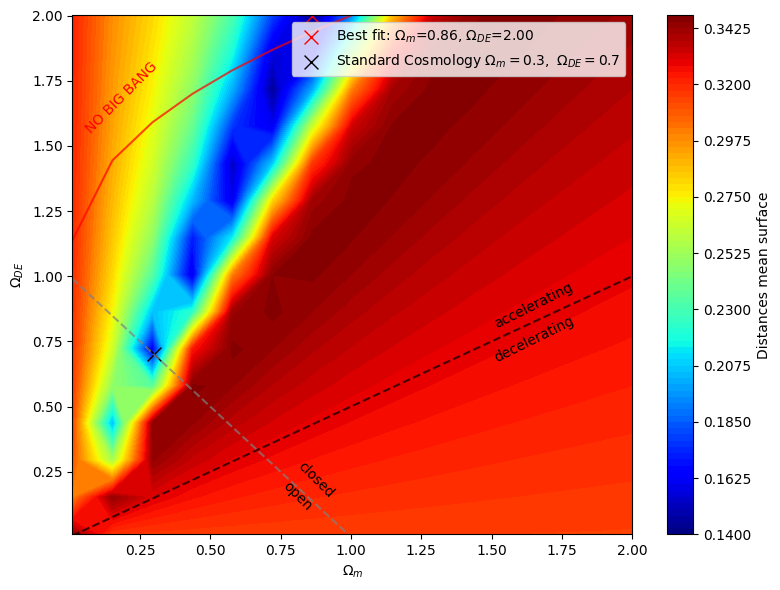

In [10]:
plot = create_contourplot(Om, Ode, medians, datatype='distances')
add_constraint_lines(plot)

Best fit: Om=0.436, Ode=1.005
Minimum average distance: 0.0461


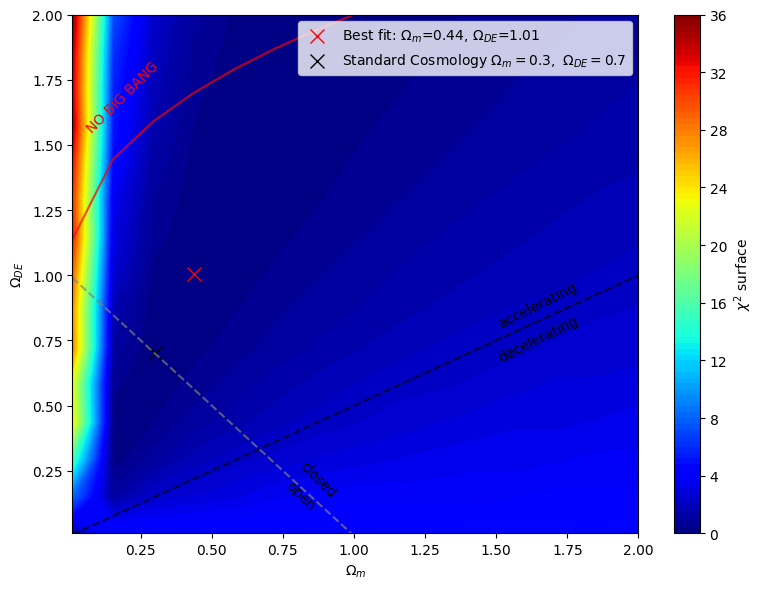

In [11]:
plot = create_contourplot(Om, Ode, chi_surface)
add_constraint_lines(plot)

Next, we'll proceed to compute the uncertainty constraints on the final results.

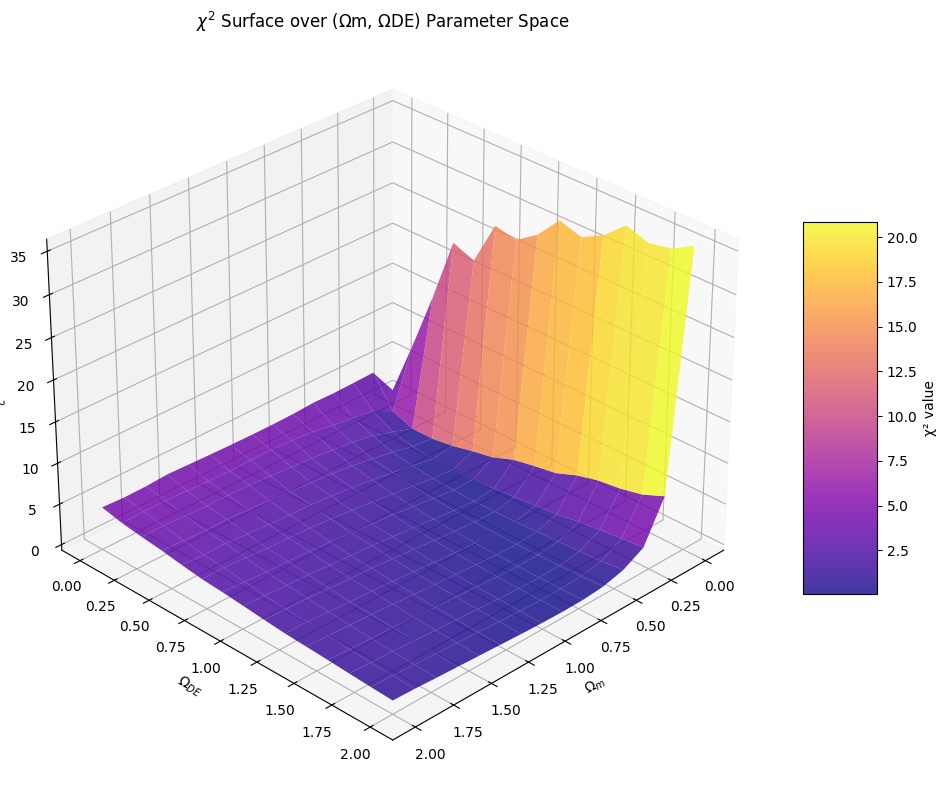

In [16]:
# Create the 3D plot
Om_mesh, Ode_mesh = np.meshgrid(Om, Ode)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(Om_mesh, Ode_mesh, chi_surface.T, cmap='plasma', alpha=0.8)
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5, label='χ² value')

# Set labels
ax.set_xlabel(r'$\Omega_m$'); ax.set_ylabel(r'$\Omega_{DE}$'); ax.set_zlabel(r'$\chi^2$')
plt.title(r'$\chi^2$ Surface over (Ωm, ΩDE) Parameter Space'); ax.view_init(elev=30, azim=45); plt.tight_layout()

* Introduced errors for correlation fitting following $\sigma_{log,x} = \log_{10}(e)\ \sigma_x/x$
* I've updated the code to use the `reduced_chi_GoF` following $\chi^2 = \frac{\sum_i \left(E_\text{peak, i}-E_\text{iso, i}(d_L)\right)^2}{\sigma_{E_p} ^2 - \sigma_{E_\text{iso}} ^2 \color{lightblue}{+ \sigma_\text{extra} ^2}}$ and $\chi^2_{r} = \chi^2/(75-2)$.
* Updated the calculation of $E_\text{iso}$, now converting between cosmologies instead of using the Fluence data $\left( E_\text{iso} \left(\Omega_m, \Omega_{DE}\right) = \frac{d_L \left(z, \Omega_m, \Omega_{DE}\right)}{d_L \left(z, \Omega_{m,0}, \Omega_{DE, 0}\right)} E_\text{iso} \left(\Omega_{m, 0}, \Omega_{DE, 0}\right)\right)$
* Plotting $\chi_r^2$ surface instead of 'mean distances' surface
* Final surface is still not circular-shaped -> final parameter uncertainty constraints?